In [1]:
# Качаем данные
!gdown 1nCHCT5XWio5fSN0mYNwRbEzTGL_sIcN4

Downloading...
From: https://drive.google.com/uc?id=1nCHCT5XWio5fSN0mYNwRbEzTGL_sIcN4
To: /content/loan_data.csv
100% 3.61M/3.61M [00:00<00:00, 52.2MB/s]


# Домашнее Задание

In [71]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report

In [3]:
df = pd.read_csv('loan_data.csv')

target = 'loan_status'

df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


## Logistic Regression (Своими Силами)

1. Дописать код градиентного спуска ниже
2. Поиграться с датасетом, предложеннным выше
3. Построить свою версию Логистической регресии (на каком-то одном числовом факторе без пропусков), сравнить результаты с LogisticRegression из SKlearn (Оценить метрики - ROC AUC, подобрать порог и Построить Confusion Matrix, а так же производные метрики от неё )
4. Заполнить пропуски, обработать категориальные переменные, обучить свою версию модели и Logistic Regression, сравнить качество между ними (см п.3) + с моделями из п.3 (как добавление бОльшего количества факторов влияет на качество модели)
5. *Поиграться с нормировкой данных (sklearn.model_selection.StandardScaler) оценить эффект на веса модели и её качество
6. Разбить факторы на Клиентские/Продуктовые/Кредитная История и построить по одной модели на каждом факторе. Затем построить мета-модель (интегральная модель) на трёх факторах - скорах метамоделях (дрейверы) - Сравнить результаты по каждому из драйеров + интегральной модели с одной моделью на всём факторном прстранстве.
7. *Привести график качества (ROC AUC) модели на фиксированной тренировочной выборке в зависимости от количества наблюдений, которые используются при обучении (train выборка). Например: 100, 500, 1000 и тд.

*- задания со звёздочкой, не обязательно, но довольно интересные

In [4]:
def sigmoid(z):
  return 1.0/(1.0+np.exp(-z))

def logloss(y, p):
    return -(y*np.log(p) + (1-y)*np.log(1-p)).mean()

In [101]:
# Реализуем собственный класс логистической регрессии
class MyLogisticRegression:
    def __init__(self, lr=1e-4, bias=True, verbose=False):
      self.bias = bool(bias)
      self.weights = None
      self.lr = lr
      self.verbose = verbose

    def preproc_x(self, X):
      X = np.array(X)
      return np.hstack([np.ones((X.shape[0], 1)), X]) if self.bias else X

    def fit(self, X, y, c_epoch=1000):
      # Инициализируем веса
      y = np.array(y)
      self.weights = np.ones(X.shape[1]+self.bias)

      self.X = self.preproc_x(X)
      self.y = y

      # Стохастический градиентный спуск
      # Итерируемся по количеству эпох
      for i in range(c_epoch):
        # Перешмешиваем наблюдения случайным образом
        ids = list(range(self.X.shape[0]))
        np.random.shuffle(ids)

        # итерируемся по наблюдениям
        for j in ids:
          p = sigmoid(np.dot(self.X[j], self.weights))
          self.weights += self.lr * (y[j] - p) * self.X[j]

        if self.verbose and i % 100 == 0:
          sigm = sigmoid(self.X @ self.weights)
          print(i , ':', logloss(self.y, sigm))

    def predict_proba(self, X):
      X = self.preproc_x(X)
      return sigmoid((X @ self.weights)*1)

    def predict(self, X):
      X = self.preproc_x(X)
      preds = (sigmoid((X @ self.weights)*1) > 0.5).astype(int)
      return preds

In [7]:
# Считываем скачанный csv файл
df = pd.read_csv('loan_data.csv')

### EDA

In [8]:
from numpy import random
# зашумим часть данных для дальнейшего интереса :-)

# Зашумим случаный 1000 возрастов (может быть меньше с учетом коллизий индексов)
# Это даст нам случайное распределение пустот
df.loc[random.choice(range(df.shape[0]), 1000), 'person_age'] = np.nan

# Уберём значительную часть доходов у людей, которые хотят взять кредит на образование
# Это зашумление нам даст неслучайное смещение
df.loc[df[df['loan_intent'] == 'EDUCATION'].sample(3000).index, 'person_income'] = np.nan

In [10]:
# Разбить на train и test выборки
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [11]:
corr = train.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
person_age,1.000000,0.209156,0.953954,0.051782,0.014425,-0.042542,0.860877,0.175251,-0.020403
person_income,0.209156,1.000000,0.201196,0.226727,0.002202,-0.224042,0.125713,0.039297,-0.128993
person_emp_exp,0.953954,0.201196,1.000000,0.047076,0.018456,-0.037695,0.822347,0.182207,-0.018637
loan_amnt,0.051782,0.226727,0.047076,1.000000,0.148872,0.590625,0.046456,0.013280,0.111054
loan_int_rate,0.014425,0.002202,0.018456,0.148872,1.000000,0.127655,0.019407,0.013597,0.332102
loan_percent_income,-0.042542,-0.224042,-0.037695,0.590625,0.127655,1.000000,-0.029319,-0.008708,0.390145
cb_person_cred_hist_length,0.860877,0.125713,0.822347,0.046456,0.019407,-0.029319,1.000000,0.149928,-0.013612
credit_score,0.175251,0.039297,0.182207,0.013280,0.013597,-0.008708,0.149928,1.000000,-0.006488
loan_status,-0.020403,-0.128993,-0.018637,0.111054,0.332102,0.390145,-0.013612,-0.006488,1.000000


Самый коррелирующий фактор с таргетом - loan_percent_income.

Построим график распределение таргета и loan_percent_income

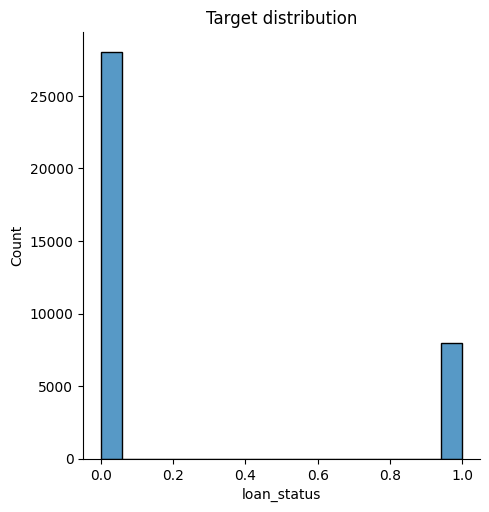

In [16]:
sns.displot(train['loan_status'])
plt.title('Target distribution');

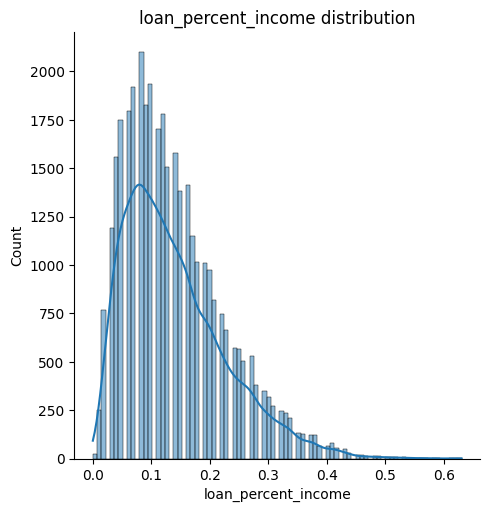

In [18]:
sns.displot(train['loan_percent_income'], kde=True)
plt.title('loan_percent_income distribution');

In [19]:
train['is_nan_age'] = train['person_age'].isna().astype(int)
train['is_nan_income'] = train['person_income'].isna().astype(int)

In [23]:
display(train.groupby('is_nan_age')['loan_status'].mean())
print('---' * 20)
display(train.groupby('is_nan_income')['loan_status'].mean())

,loan_status
is_nan_age,
0,0.222393
1,0.202020


------------------------------------------------------------


,loan_status
is_nan_income,
0,0.226181
1,0.163517


### Логическая регрессия на одном признаке

In [42]:
X = train['loan_percent_income'].values
y = train[target].values

In [49]:
# Обучить свою версию и sklearn'овскую версию Логистической Регрессии

my_lr = MyLogisticRegression(verbose=True)
sk_lr = LogisticRegression()

my_lr.fit(X.reshape(-1, 1), y, 500)
sk_lr.fit(X.reshape(-1, 1), y)

0 : 0.6306221500378417
100 : 0.4808511119658328
200 : 0.4665972231384799
300 : 0.4610931127730679
400 : 0.4588355877072082


LogisticRegression()

In [51]:
X_test = test['loan_percent_income'].values
y_test = test[target].values

#### Результаты

My ROC AUC: 0.7077318699777222
Sklearn ROC AUC: 0.7077318699777222


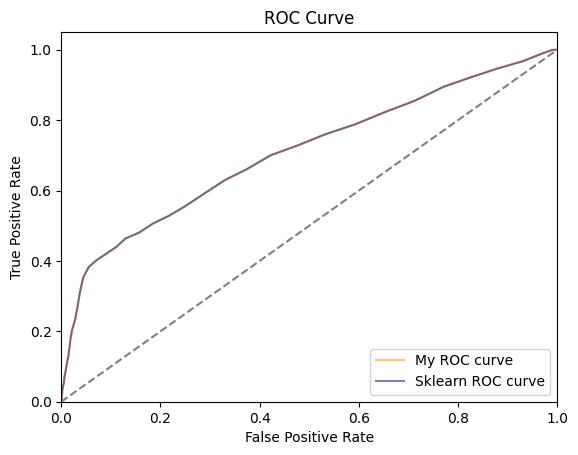

In [65]:
my_proba = my_lr.predict_proba(X_test.reshape(-1, 1))
sk_proba = sk_lr.predict_proba(X_test.reshape(-1, 1))[:, 1]

print("My ROC AUC:", roc_auc_score(y_test, my_proba))
print("Sklearn ROC AUC:", roc_auc_score(y_test, sk_proba))

fpr_my, tpr_my, _ = roc_curve(y_test, my_proba)
roc_auc_my = auc(fpr_my, tpr_my)

fpr_sk, tpr_sk, _ = roc_curve(y_test, sk_proba)
roc_auc_sk = auc(fpr_sk, tpr_sk)

plt.plot(fpr_my, tpr_my, color='darkorange', label='My ROC curve' % roc_auc_my, alpha=0.5)
plt.plot(fpr_sk, tpr_sk, color='navy', label='Sklearn ROC curve' % roc_auc_sk, alpha=0.5)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

My Confusion Matrix:


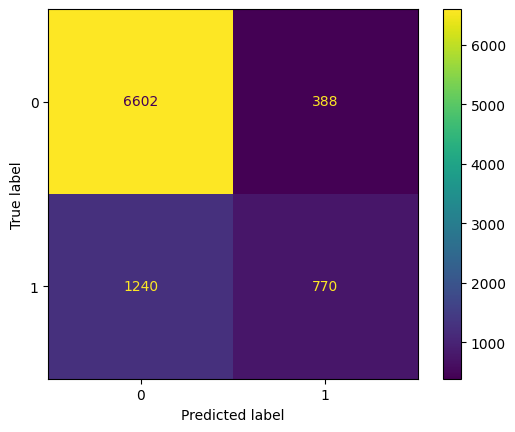


Sklearn Confusion Matrix:


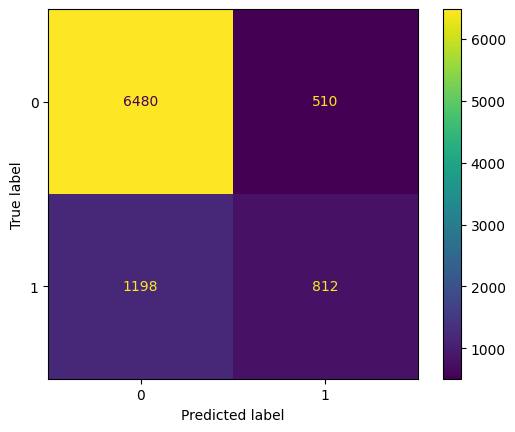

In [83]:
threshold = 0.4
y_pred_my = (my_proba > threshold).astype(int)
y_pred_sk = (sk_proba > threshold).astype(int)

print("My Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_my)
plt.show()
print("\nSklearn Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_sk)
plt.show()

In [84]:
print(classification_report(y_test, y_pred_my))
print('---'*20)
print(classification_report(y_test, y_pred_sk))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      6990
           1       0.66      0.38      0.49      2010

    accuracy                           0.82      9000
   macro avg       0.75      0.66      0.69      9000
weighted avg       0.80      0.82      0.80      9000

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      6990
           1       0.61      0.40      0.49      2010

    accuracy                           0.81      9000
   macro avg       0.73      0.67      0.69      9000
weighted avg       0.79      0.81      0.80      9000



Как видно, у модели есть слабое место в виде классификации класса 1.     
recall(1) = 0.38, f1-score(1) = 0.49


### Модель на всех признаках

In [85]:
X_train = train.drop(columns=[target])
X_test = test.drop(columns=[target])

y_train = train[target]
y_test = test[target]

In [94]:
num_cols = X_test.select_dtypes(include=np.number).columns
cat_cols = X_test.select_dtypes(exclude=np.number).columns

In [90]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#### Строим пайплайн препроцессора

In [155]:
numeric_transformer = Pipeline(steps=[
    ("impute_median", SimpleImputer(strategy="median",
                                    add_indicator=False)),
    ("scale", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop"
)

Преобразуем данные

In [156]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

In [157]:
my_lr = MyLogisticRegression(verbose=True, lr=1e-3)
sk_lr = LogisticRegression()

my_lr.fit(X_train_prep, y_train, 500)
sk_lr.fit(X_train_prep, y_train)

0 : 0.25769873123868137
100 : 0.22028230372967386
200 : 0.22022253897722913
300 : 0.22018224450831633
400 : 0.22013229897153308


LogisticRegression()

#### Результаты

My ROC AUC: 0.952628701983644
Sklearn ROC AUC: 0.9526904817827886


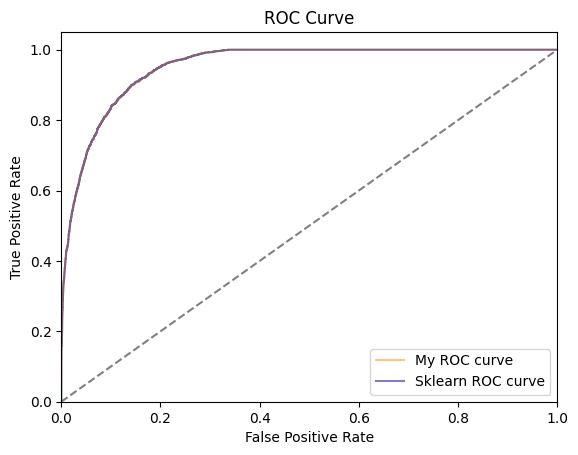

In [103]:
my_proba = my_lr.predict_proba(X_test_prep)
sk_proba = sk_lr.predict_proba(X_test_prep)[:, 1]

print("My ROC AUC:", roc_auc_score(y_test, my_proba))
print("Sklearn ROC AUC:", roc_auc_score(y_test, sk_proba))

fpr_my, tpr_my, _ = roc_curve(y_test, my_proba)
roc_auc_my = auc(fpr_my, tpr_my)

fpr_sk, tpr_sk, _ = roc_curve(y_test, sk_proba)
roc_auc_sk = auc(fpr_sk, tpr_sk)

plt.plot(fpr_my, tpr_my, color='darkorange', label='My ROC curve' % roc_auc_my, alpha=0.5)
plt.plot(fpr_sk, tpr_sk, color='navy', label='Sklearn ROC curve' % roc_auc_sk, alpha=0.5)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Как видно ROC AUC = 0.95, что очень хорошо.    
Так же по графику видно, что ROC кривая совпадает

My Confusion Matrix:


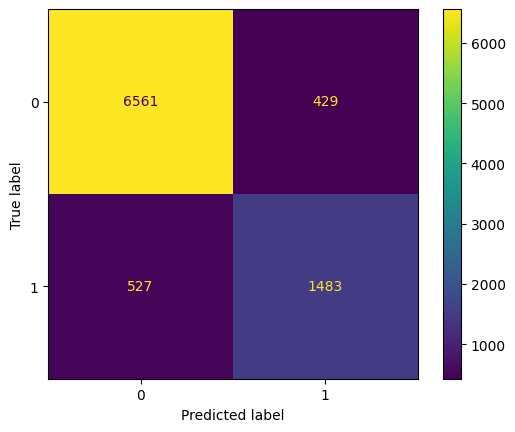


Sklearn Confusion Matrix:


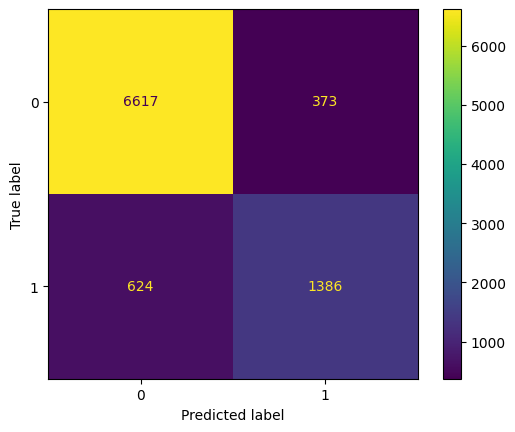

In [158]:
threshold = 0.5
y_pred_my = (my_proba > threshold).astype(int)
y_pred_sk = (sk_proba > threshold).astype(int)

print("My Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_my)
plt.show()
print("\nSklearn Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_sk)
plt.show()

In [112]:
print(classification_report(y_test, y_pred_my))
print('---'*20)
print(classification_report(y_test, y_pred_sk))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      6990
           1       0.78      0.74      0.76      2010

    accuracy                           0.89      9000
   macro avg       0.85      0.84      0.84      9000
weighted avg       0.89      0.89      0.89      9000

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      6990
           1       0.78      0.74      0.76      2010

    accuracy                           0.89      9000
   macro avg       0.85      0.84      0.85      9000
weighted avg       0.89      0.89      0.89      9000



Модели, обученные на всех признаках показывают гораздно лучший результат (ROC AUC = 0.95, f1=0.85). У моделей сохраняется небольшая проблема с определением класса 1, однако они гораздно лучше определяют классы в сравнении с моделями, обученными на одном признаке.    
Разница между реализациями регрессии в рамках погрешности

### Мета модель

In [113]:
test.columns

Index(['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'previous_loan_defaults_on_file', 'loan_status'],
      dtype='object')

#### Выделяем группы признаков

In [142]:
person_cols = [x for x in X_test.columns if x.startswith('person')]
loan_cols = [x for x in X_test.columns if x.startswith('loan') and x not in ['loan_status']]
credit_hist_cols = [x for x in X_test.columns if x not in person_cols and x not in loan_cols]

In [143]:
X_train[person_cols]

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership
25180,34.0,female,Bachelor,97265.0,11,MORTGAGE
12555,25.0,male,High School,72953.0,3,RENT
29153,41.0,female,Master,322597.0,18,MORTGAGE
23838,27.0,male,Associate,94232.0,4,RENT
35686,27.0,male,Master,84873.0,7,RENT
...,...,...,...,...,...,...
11284,26.0,male,High School,88451.0,6,MORTGAGE
44732,25.0,female,High School,34772.0,3,MORTGAGE
38158,33.0,female,Associate,58317.0,9,MORTGAGE
860,26.0,male,Master,178602.0,6,RENT


Находим категориальные и численные признаки в каждой группе

In [144]:
cat_person = X_test[person_cols].select_dtypes(exclude=np.number).columns
cat_loan = X_test[loan_cols].select_dtypes(exclude=np.number).columns
cat_credit_hist = X_test[credit_hist_cols].select_dtypes(exclude=np.number).columns

num_person = X_test[person_cols].select_dtypes(include=np.number).columns
num_loan = X_test[loan_cols].select_dtypes(include=np.number).columns
num_credit_hist = X_test[credit_hist_cols].select_dtypes(include=np.number).columns

#### Делаем пайплайн мета модели.

In [145]:
def make_preprocessor(num_cols, cat_cols):
    num_pipe = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    cat_pipe = Pipeline([
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    return ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop")

In [146]:
person_pipe = Pipeline([
    ("prep", make_preprocessor(num_person, cat_person)),
    ("log", LogisticRegression(max_iter=1000, n_jobs=-1))
])

loan_pipe = Pipeline([
    ("prep", make_preprocessor(num_loan, cat_loan)),
    ("log", LogisticRegression(max_iter=1000, n_jobs=-1))
])

cred_pipe = Pipeline([
    ("prep", make_preprocessor(num_credit_hist, cat_credit_hist)),
    ("log", LogisticRegression(max_iter=1000, n_jobs=-1))
])

In [147]:
from sklearn.ensemble import StackingClassifier

In [148]:
stack = StackingClassifier(
    estimators=[
        ("person", person_pipe),
        ("loan",   loan_pipe),
        ("cred",   cred_pipe)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    stack_method="predict_proba",
    cv=5,
    n_jobs=-1
)

Обучаем

In [149]:
stack.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('person',
                                Pipeline(steps=[('prep',
                                                 ColumnTransformer(transformers=[('num',
                                                                                  Pipeline(steps=[('impute_median',
                                                                                                   SimpleImputer(strategy='median')),
                                                                                                  ('scale',
                                                                                                   StandardScaler())]),
                                                                                  Index(['person_age', 'person_income', 'person_emp_exp'], dtype='object')),
                                                                                 ('cat',
                                                                                  Pipeline(steps=[('ohe',
                                                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                                                  In...
                                                                                                   StandardScaler())]),
                                                                                  Index(['cb_person_cred_hist_length', 'credit_score'], dtype='object')),
                                                                                 ('cat',
                                                                                  Pipeline(steps=[('ohe',
                                                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                                                  Index(['previous_loan_defaults_on_file'], dtype='object'))])),
                                                ('log',
                                                 LogisticRegression(max_iter=1000,
                                                                    n_jobs=-1))]))],
                   final_estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
                   stack_method='predict_proba')

#### Результаты

Sklearn ROC AUC: 0.9448697143751912


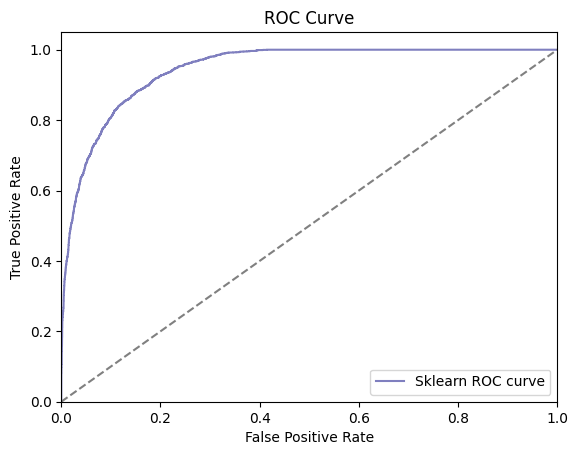

In [151]:
sk_proba = stack.predict_proba(X_test)[:, 1]

print("Sklearn ROC AUC:", roc_auc_score(y_test, sk_proba))

fpr_sk, tpr_sk, _ = roc_curve(y_test, sk_proba)
roc_auc_sk = auc(fpr_sk, tpr_sk)

plt.plot(fpr_sk, tpr_sk, color='navy', label='Sklearn ROC curve' % roc_auc_sk, alpha=0.5)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

ROC AUC = 0.94, что так же хороший результат, но немного хуже, чем у предыдущей модели


Sklearn Confusion Matrix:


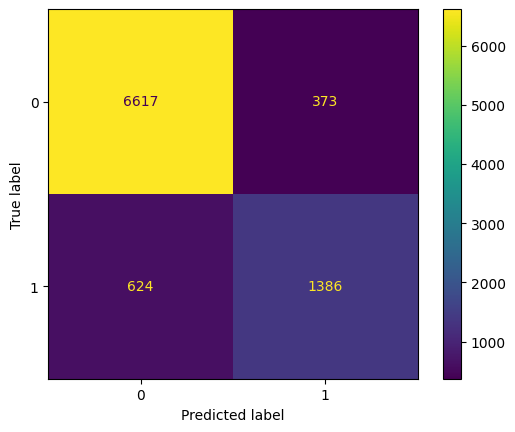

In [152]:
threshold = 0.5
y_pred_sk = (sk_proba > threshold).astype(int)

print("\nSklearn Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_sk)
plt.show()

In [153]:
print(classification_report(y_test, y_pred_sk))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      6990
           1       0.79      0.69      0.74      2010

    accuracy                           0.89      9000
   macro avg       0.85      0.82      0.83      9000
weighted avg       0.89      0.89      0.89      9000



У модели сохраняется проблема с определением класса 1.